## Impose fabrication constraints
Now that we've seen a basic inverse design, it's time to make a device that can actually be fabricated

In [5]:
import argparse

import numpy as np
import autograd.numpy as npa

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

## Operators for device parameterization

In [6]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    """
    return npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                        npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

# Blurring filter that results in smooth features of the structure
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle filter, higher radius -> smoother features
    """
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

### Visualization of the projection

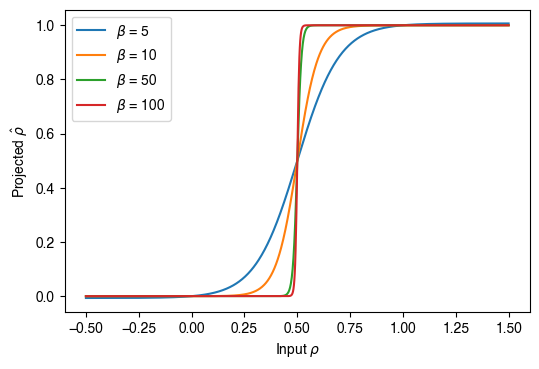

In [7]:
rho = np.linspace(-0.5, +1.5, 999)

# Visualize different values of the projection strength
plt.figure()
for beta in [5, 10, 50, 100]:
    plt.plot(rho, operator_proj(rho, beta=beta), label=r"$\beta$ = %d" % beta)

plt.xlabel(r"Input $\rho$")
plt.ylabel(r"Projected $\hat{\rho}$")
plt.legend()
plt.show()

### Visualization of the blur

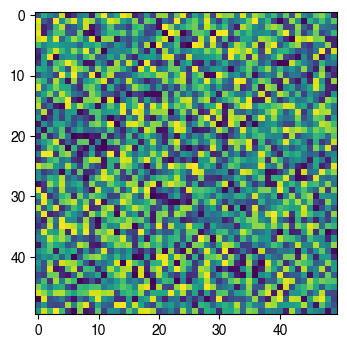

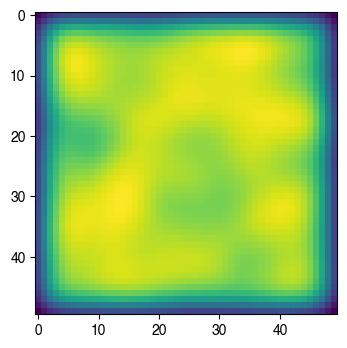

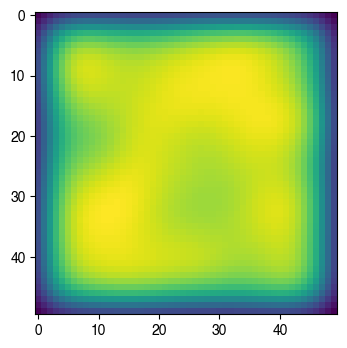

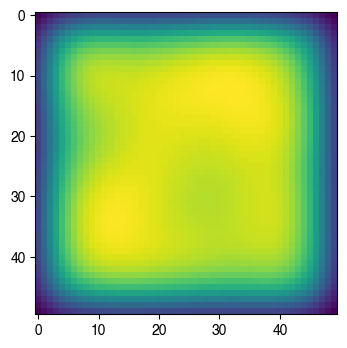

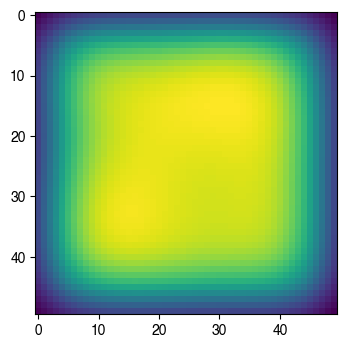

In [11]:
rho = np.random.rand(50, 50)

# Visualize different values of the blur radius
for radius in [None, 2, 3, 4, 5]:
    plt.figure()
    rho_p = operator_blur(rho, radius=radius, N=5) if radius is not None else rho
    plt.imshow(rho_p)
plt.show()

## Some helper functions as before

In [22]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    
    # Output probe slice
    output_slice = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5

    return rho, design_region, input_slice, output_slice

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)

def make_rho(rho, design_region, radius=2, blur_applications=1):
    """Helper function for applying the blur to only the design region
    """
    lpf_rho = operator_blur(rho, radius=radius, N=blur_applications) * design_region
    bg_rho = rho * (design_region==0).astype(np.float)
    return bg_rho + lpf_rho

## Parameters
Feel free to explore what happens as you run the optimization with different parameters, especially `blur_radius` and `beta`.

In [38]:
# Number of epochs in the optimization 
Nsteps=30
# Step size for the Adam optimizer
step_size=1e-2
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=5
# Number of times to apply the smoothening
blur_applications=5
# Strength of the binarizing projection
beta=500.0
# Middle point of the binarizing projection
eta=0.5
# Space between the PMLs and the design region (in pixels)
space=default=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

## Simulate the initial structure
Note that the blurring effect is already visible.

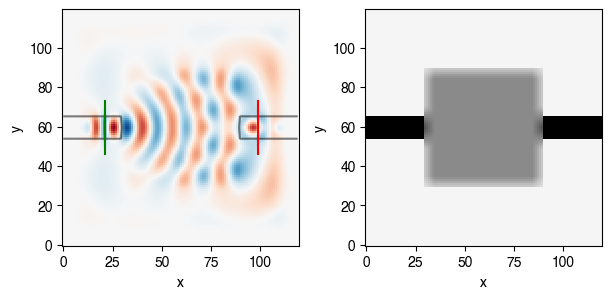

In [39]:
# Initialize the parametrization rho and the design region
rho_init, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_min + (epsr_max-epsr_min) * make_rho(rho_init, design_region, radius=blur_radius)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr_init)

## Run the mode converter optimization

Epoch:   1/ 30 | Duration: 0.20 secs | Value: 7.003939e-14
Epoch:   2/ 30 | Duration: 0.20 secs | Value: 1.895779e-06
Epoch:   3/ 30 | Duration: 0.20 secs | Value: 2.084883e-06
Epoch:   4/ 30 | Duration: 0.20 secs | Value: 2.224982e-06
Epoch:   5/ 30 | Duration: 0.20 secs | Value: 2.309986e-06
Epoch:   6/ 30 | Duration: 0.19 secs | Value: 2.355574e-06
Epoch:   7/ 30 | Duration: 0.19 secs | Value: 2.427931e-06
Epoch:   8/ 30 | Duration: 0.18 secs | Value: 2.473263e-06
Epoch:   9/ 30 | Duration: 0.19 secs | Value: 2.502610e-06
Epoch:  10/ 30 | Duration: 0.18 secs | Value: 2.516582e-06
Epoch:  11/ 30 | Duration: 0.19 secs | Value: 2.528445e-06
Epoch:  12/ 30 | Duration: 0.18 secs | Value: 2.548523e-06
Epoch:  13/ 30 | Duration: 0.19 secs | Value: 2.559220e-06
Epoch:  14/ 30 | Duration: 0.18 secs | Value: 2.562280e-06
Epoch:  15/ 30 | Duration: 0.19 secs | Value: 2.565392e-06
Epoch:  16/ 30 | Duration: 0.19 secs | Value: 2.569921e-06
Epoch:  17/ 30 | Duration: 0.19 secs | Value: 2.574455e-

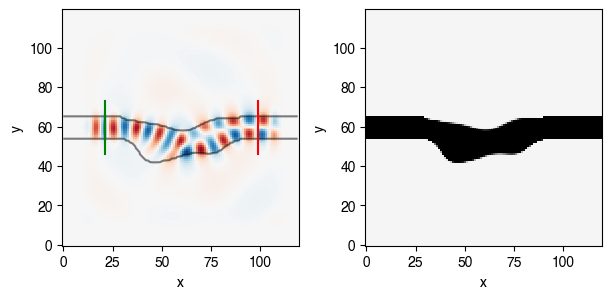

In [40]:
# Define optimization objective
def measure_modes(Ez):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(Ez)*probe))

def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    _rho = make_rho(rho, design_region, radius=blur_radius, blur_applications=blur_applications)
    epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(_rho, beta=beta, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', 
                         mask=design_region.flatten(), step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(make_rho(rho_optimum, 
                        design_region, radius=blur_radius, blur_applications=blur_applications), beta=beta, eta=eta)
simulation, ax = viz_sim(epsr)

## Trying a penality term to remove extra material

In [41]:
def objective(rho, penalty=1e-7):
    rho = rho.reshape((Nx, Ny))
    _rho = make_rho(rho, design_region, radius=blur_radius)
    epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(_rho, beta=200, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez) - _rho.sum()*penalty

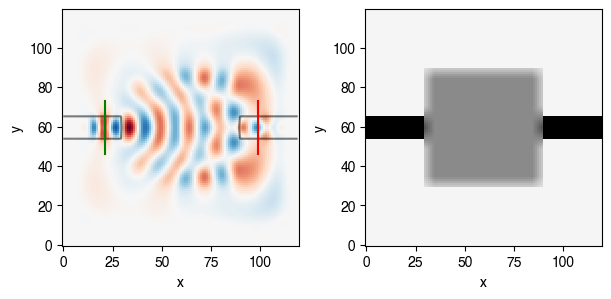

Epoch:   1/ 30 | Duration: 0.16 secs | Value: -2.402275e-04
Epoch:   2/ 30 | Duration: 0.16 secs | Value: -2.396716e-04
Epoch:   3/ 30 | Duration: 0.17 secs | Value: -2.376838e-04
Epoch:   4/ 30 | Duration: 0.16 secs | Value: -2.365133e-04
Epoch:   5/ 30 | Duration: 0.16 secs | Value: -2.354017e-04
Epoch:   6/ 30 | Duration: 0.15 secs | Value: -2.344388e-04
Epoch:   7/ 30 | Duration: 0.15 secs | Value: -2.332414e-04
Epoch:   8/ 30 | Duration: 0.15 secs | Value: -2.321165e-04
Epoch:   9/ 30 | Duration: 0.16 secs | Value: -2.310108e-04
Epoch:  10/ 30 | Duration: 0.15 secs | Value: -2.299255e-04
Epoch:  11/ 30 | Duration: 0.15 secs | Value: -2.288447e-04
Epoch:  12/ 30 | Duration: 0.15 secs | Value: -2.277594e-04
Epoch:  13/ 30 | Duration: 0.15 secs | Value: -2.266932e-04
Epoch:  14/ 30 | Duration: 0.15 secs | Value: -2.256079e-04
Epoch:  15/ 30 | Duration: 0.16 secs | Value: -2.245338e-04
Epoch:  16/ 30 | Duration: 0.15 secs | Value: -2.234628e-04
Epoch:  17/ 30 | Duration: 0.15 secs | V

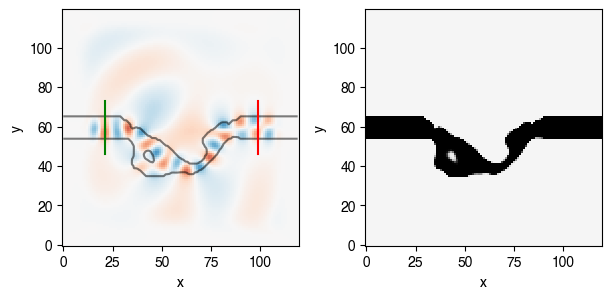

In [42]:
# Setup initial structure
rho_init, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)
epsr = epsr_min + (epsr_max-epsr_min) * make_rho(rho_init, design_region, radius=blur_radius)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr)

# Run optimization
objective_jac = jacobian(objective, mode='reverse')
(rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', 
                         mask=design_region.flatten(), step_size=step_size)
rho_optimum = rho_optimum.reshape((Nx, Ny))

# Simulate optimal device
epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(make_rho(rho_optimum, 
                        design_region, radius=blur_radius), beta=beta, eta=eta)
simulation, ax = viz_sim(epsr)

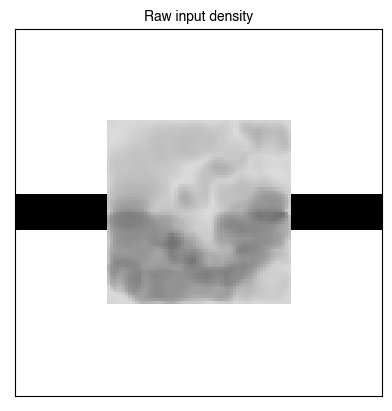

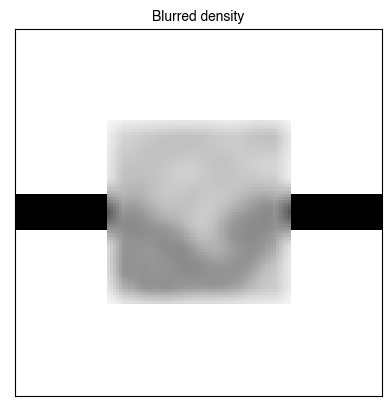

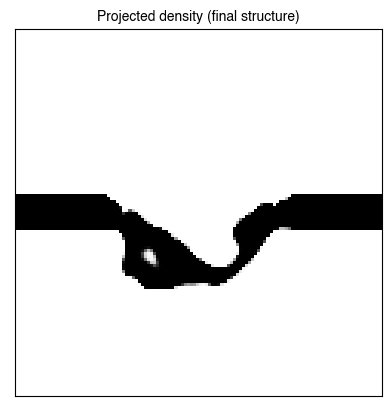

In [57]:
Z = rho_optimum
ax = ceviche.viz.abs(rho_optimum, cmap='Greys')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('Raw input density')

Z = make_rho(rho_optimum, design_region, radius=blur_radius)
ax = ceviche.viz.abs(Z, cmap='Greys')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('Blurred density')

Z = operator_proj(make_rho(rho_optimum, design_region, radius=blur_radius), beta=beta, eta=eta)
ax = ceviche.viz.abs(Z, cmap='Greys')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('')
ax.set_title('Projected density (final structure)');